In [1]:
#During submission internet is disabled. Hence install this package manually
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [2]:
!apt-get install -y graphviz libgraphviz-dev libcgraph6

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
libcgraph6 is already the newest version (2.42.2-6).
libcgraph6 set to manually installed.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-2 librsvg2-common libxdot4
Suggested packages:
  gvfs librsvg2-bin
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
The following packages will be upgraded:
  librsvg2-2
1 upgraded, 9 newly installed, 0 to remove and 73 not upgraded.
Need to get 5406 kB of archives.
After this operation, 7363 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu

In [3]:
!pip install git+https://github.com/danielegrattarola/spektral

  Cloning https://github.com/danielegrattarola/spektral to /tmp/pip-req-build-7g5y6vln
  Running command git clone --filter=blob:none --quiet https://github.com/danielegrattarola/spektral /tmp/pip-req-build-7g5y6vln
  Resolved https://github.com/danielegrattarola/spektral to commit a5fa5e38fca4eaca1e47ccfe1b00e0a61f64648b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spektral: filename=spektral-1.3.1-py3-none-any.whl size=140162 sha256=4b840332d2458828aaad5b7bb4ffbc7acc8316e537e376fb63caa103d1da3ae9
  Stored in directory: /tmp/pip-ephem-wheel-cache-b6cyn5bz/wheels/02/e2/81/95bc0d8fb087de2ca12e892947cd5bfc3ec1046599312faf16
Successfully built spektral


In [4]:
import pandas as pd
import numpy as np
import pydicom as dicom
import glob
import nibabel as nib
import os
import re
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3, DenseNet121, InceptionResNetV2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
base_dir = r'/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
train_images = os.path.join(base_dir,'train_images')
test_images = os.path.join(base_dir,'test_images')
train_df = pd.read_csv(os.path.join(base_dir,'train.csv'))
segmentation_meta_data = pd.read_csv(r'/kaggle/input/rsna-cervical-fracture-segmentation-metadata/meta_segmentation.csv')

In [6]:
segmentation_meta_data.shape

(29832, 26)

In [7]:
segmentation_meta_data.columns

Index(['Rows', 'Columns', 'SOPInstanceUID', 'ContentDate', 'SliceThickness',
       'InstanceNumber', 'ImagePositionPatientX', 'ImagePositionPatientY',
       'ImagePositionPatientZ', 'PhotometricInterpretation', 'PixelSpacingX',
       'PixelSpacingY', 'WindowCenter', 'WindowWidth', 'RescaleIntercept',
       'RescaleSlope', 'StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'Slice', 'SliceRatio'],
      dtype='object')

In [8]:
columns = ['StudyInstanceUID','SOPInstanceUID','C1','C2','C3','C4','C5','C6','C7']

In [9]:
seg_labels = segmentation_meta_data[columns]

In [10]:
seg_labels.head(2)

,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0


In [11]:
#Get Slice instance number
seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1:][0])
seg_labels

/tmp/ipykernel_32/452365418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1:][0])


,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7,slice
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0,12
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0,120
2,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.141,0,0,0,0,0,1,1,141
3,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.18,0,0,0,0,0,0,0,18
4,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.9,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...
29827,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.26,0,0,0,0,0,0,0,26
29828,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.185,0,0,0,0,0,1,1,185
29829,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.221,0,0,0,0,0,0,0,221
29830,1.2.826.0.1.3680043.26990,1.2.826.0.1.3680043.26990.1.13,0,0,0,0,0,0,0,13


In [12]:
# Function to load DICOM images
def load_scan(dcm_paths):  
    patient_scan = [dicom.dcmread(paths) for paths in dcm_paths]
    return patient_scan

def get_pixels_hu(img):
    image = cv2.resize(img.pixel_array,(128, 128),interpolation = cv2.INTER_NEAREST)
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0, the intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    # Convert to Hounsfield units (HU)    
    intercept = np.array(img.RescaleIntercept)
    slope = np.array(img.RescaleSlope)
    image= (slope * image.astype("float64")) + intercept
#     plt.imshow(image.astype("int16"), cmap='bone') 
    return image.astype("int16")

In [13]:
list(seg_labels['StudyInstanceUID'].unique())

['1.2.826.0.1.3680043.1363',
 '1.2.826.0.1.3680043.25704',
 '1.2.826.0.1.3680043.20647',
 '1.2.826.0.1.3680043.31077',
 '1.2.826.0.1.3680043.17960',
 '1.2.826.0.1.3680043.1573',
 '1.2.826.0.1.3680043.18935',
 '1.2.826.0.1.3680043.1868',
 '1.2.826.0.1.3680043.26442',
 '1.2.826.0.1.3680043.27752',
 '1.2.826.0.1.3680043.12281',
 '1.2.826.0.1.3680043.26068',
 '1.2.826.0.1.3680043.8024',
 '1.2.826.0.1.3680043.11827',
 '1.2.826.0.1.3680043.1542',
 '1.2.826.0.1.3680043.26740',
 '1.2.826.0.1.3680043.26898',
 '1.2.826.0.1.3680043.16092',
 '1.2.826.0.1.3680043.8744',
 '1.2.826.0.1.3680043.8884',
 '1.2.826.0.1.3680043.5002',
 '1.2.826.0.1.3680043.3992',
 '1.2.826.0.1.3680043.20120',
 '1.2.826.0.1.3680043.780',
 '1.2.826.0.1.3680043.30067',
 '1.2.826.0.1.3680043.5671',
 '1.2.826.0.1.3680043.18968',
 '1.2.826.0.1.3680043.26979',
 '1.2.826.0.1.3680043.21651',
 '1.2.826.0.1.3680043.17481',
 '1.2.826.0.1.3680043.27016',
 '1.2.826.0.1.3680043.1480',
 '1.2.826.0.1.3680043.18480',
 '1.2.826.0.1.3680043.1

In [14]:
def get_image(study_instance):
    path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'
    # study_instances = list(seg_labels['StudyInstanceUID'].unique())
    patient_slices = []
    org_images = []
#     study_instance = '1.2.826.0.1.3680043.1868'
    # for study_instance in study_instances:
    slices = list(seg_labels[seg_labels['StudyInstanceUID']==study_instance]['slice'])
    dcm_paths = [path+'/'+study_instance+'/'+ slic + '.dcm' for slic in slices]
    image = load_scan(dcm_paths)
    org_images.append(image)
    slices_p = [dicom.read_file(dcm_path) for dcm_path in dcm_paths]
    patient_slice = [get_pixels_hu(slic) for slic in slices_p]
    patient_slices.append(patient_slice)
    
    return org_images, patient_slices, slices

In [15]:
study_instance = '1.2.826.0.1.3680043.1868'
org_images, patient_slices, slices = get_image(study_instance = study_instance)

In [16]:
dat  = seg_labels[seg_labels['StudyInstanceUID']==study_instance][['SOPInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
dat

,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
2273,1.2.826.0.1.3680043.1868.1.377,0,0,0,0,1,1,0
2274,1.2.826.0.1.3680043.1868.1.257,0,1,1,0,0,0,0
2275,1.2.826.0.1.3680043.1868.1.240,0,1,1,0,0,0,0
2276,1.2.826.0.1.3680043.1868.1.452,0,0,0,0,0,1,1
2277,1.2.826.0.1.3680043.1868.1.553,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2921,1.2.826.0.1.3680043.1868.1.221,0,1,0,0,0,0,0
2922,1.2.826.0.1.3680043.1868.1.13,0,0,0,0,0,0,0
2923,1.2.826.0.1.3680043.1868.1.358,0,0,0,1,1,0,0
2924,1.2.826.0.1.3680043.1868.1.566,0,0,0,0,0,0,0


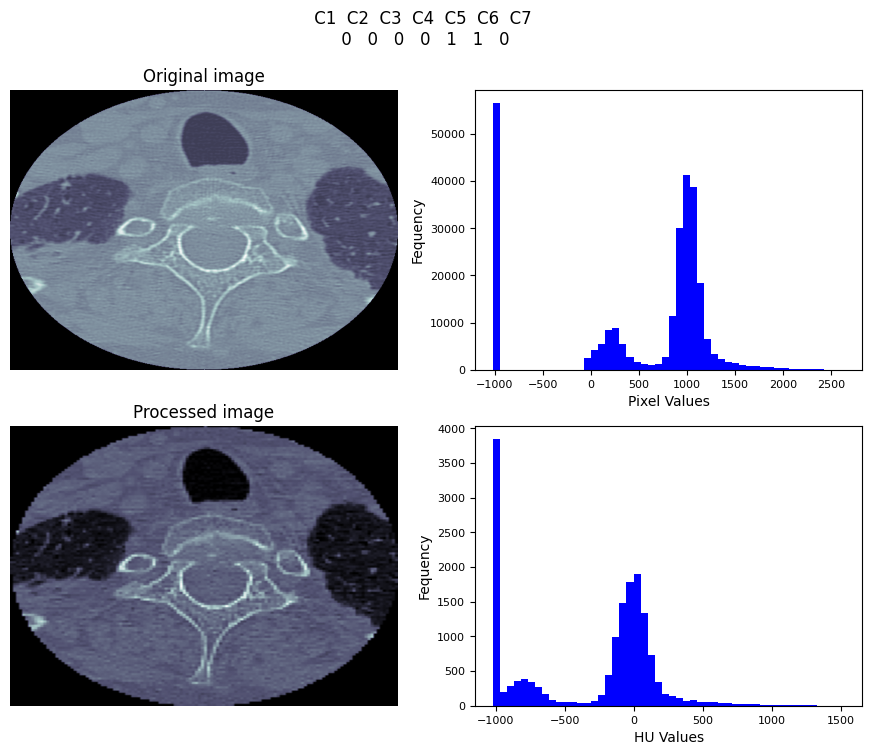

In [17]:
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

start = 0
img = 67
label = dat[dat['SOPInstanceUID']==study_instance+'.1.'+slices[start]][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].to_string(index=False).split('\n')
plt.figure(figsize=(11, 8))
# Ploting pixel array
plt.subplot(2, 2, 1)
plt.imshow(org_images[start][img].pixel_array,cmap='bone', aspect='auto')
plt.title('Original image')
plt.axis("off")

# Ploting pixel array distribution
plt.subplot(2, 2, 2)
plt.hist(org_images[start][img].pixel_array.flatten(),color="b",bins=50)
# plt.title('Pixel array distribution')
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")

#Ploting HU array
plt.subplot(2, 2, 3)
plt.imshow(get_pixels_hu(org_images[start][img]),cmap='bone', aspect='auto')
plt.title('Processed image')
plt.axis("off")

# Ploting HU distribution
plt.subplot(2, 2, 4)
plt.hist(patient_slices[start][img].flatten(),color="b",bins=50)
# plt.title('HU distribution')
plt.xlabel("HU Values")
plt.ylabel("Fequency")
plt.suptitle(f"{label[0]} \n {label[1].strip()}", y=0.98, fontsize=12)
plt.show()

In [18]:
label, label[1].split()

([' C1  C2  C3  C4  C5  C6  C7', '  0   0   0   0   1   1   0'],
 ['0', '0', '0', '0', '1', '1', '0'])

In [19]:
def load_dicom(path):
    '''
    Function to load and transform DICOM images.
    
    Parameters:
    path(string): Path to the DICOM images

    Returns:
    Transformed and resized image.
    
    '''
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
#     data=img.pixel_array
    data=get_pixels_hu(img)
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)        
    return cv2.cvtColor(data.reshape(128, 128), cv2.COLOR_GRAY2RGB)

def ImgDataGenerator(train_df,base_path):
    '''
    Function to read dicom image path and store the images as numpy arrays.

    Parameters:
    train_df: Pandas dataframe.
    base_path: Python list containing image filepaths.

    Returns:
    [Train image dataset, Train image labels]

    '''
    trainset = []
    trainlabel = []
    for i in tqdm(range(len(train_df))):
        study_id = train_df.loc[i,'StudyInstanceUID']
        slice_id = train_df.loc[i,'slice']+'.dcm'
        study_path = study_id+'/'+slice_id

        path = os.path.join(base_path, study_path)

        img = load_dicom(path)
        img = cv2.resize(img, (128 , 128))
        image = img_to_array(img)
        image = image / 255.0
        trainset += [image]
        cur_label = [train_df.loc[i,f'C{j}'] for j in range(1,8)]
        trainlabel += [cur_label]

    return np.array(trainset), np.array(trainlabel)
    
def metrics(y_test, y_pred_binary):
    '''
    Function to display accuracy, precision, recall and f1-score for the classification task.
    
    Parameters:
    y_test: True labels.
    y_pred_binary: Predicted binary labels.

    Returns:
    Pandas dataframe containing class-wise Sensitivity, Specificity, and F1-score.
    
    '''
    classes = np.array(seg_labels.columns[2:-1])
    df_res = []
    precision_per_class = precision_score(y_test, y_pred_binary, average=None)
    recall_per_class = recall_score(y_test, y_pred_binary, average=None)
    f1_per_class = f1_score(y_test, y_pred_binary, average=None)

    for i in range(len(classes)):
        df_res.append([classes[i], recall_per_class[i], precision_per_class[i], f1_per_class[i]])
    df_res = pd.DataFrame(df_res, columns = ['Class','Sensitivity','Specificity', 'F1-score'])
    return df_res

def plot_history(history):
    '''
    Function to plot the train and validation accuracy and loss.
    
    Parameters:
    history: model train history

    Returns:
    None.
    
    '''
    hist = history.history
    plt.figure(figsize=(8, 4));
    plt.suptitle(f"Performance Metrics", fontsize=12)

    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve', fontsize=8)
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['binary_accuracy'], label='train')
    plt.plot(hist['val_binary_accuracy'], label='validation')
    plt.title('Train and val accuracy curve', fontsize=8)
    plt.legend();
    
def callback(model_name, patience=5): 
    '''
    Function to define callback for model training.
    
    Parameters:
    model_name(string): Name for the saved model with `.h5` extension.
    patience: Patience for early stopping. Usually, the value lies between 5-11.

    Returns:
    [Early Stopping Callback, Model Checkpoint Callback]
    
    '''
    early_stopping = callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint(model_name, save_best_only=True)
    learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                        patience=2, 
                                                        verbose=1, 
                                                        factor=0.5, 
                                                        min_lr=0.00001)
    return [early_stopping, model_checkpoint, learning_rate_reduction]


In [20]:
# Convert train images of segmented studyids to array
X_seg, y_seg = ImgDataGenerator(seg_labels,train_images)
X_seg.shape,y_seg.shape

100%|██████████| 29832/29832 [09:56<00:00, 50.00it/s]


((29832, 128, 128, 3), (29832, 7))

In [21]:
# Divide train and test data
X_train, X_test, y_train, y_test = train_test_split(X_seg, y_seg, random_state=42, test_size=0.1)
y_train, y_test = y_train.astype('float32'), y_test.astype('float32')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26848, 128, 128, 3), (26848, 7), (2984, 128, 128, 3), (2984, 7))

In [22]:
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

# Augmentation 

In [ ]:
import tensorflow as tf

def get_cutmix_bbox(image_height, image_width, lam):
    r_x = tf.random.uniform([], 0, image_width, dtype=tf.int32)
    r_y = tf.random.uniform([], 0, image_height, dtype=tf.int32)
    r_w = tf.cast(image_width * tf.math.sqrt(1 - lam), tf.int32)
    r_h = tf.cast(image_height * tf.math.sqrt(1 - lam), tf.int32)
    x1 = tf.clip_by_value(r_x - r_w // 2, 0, image_width)
    y1 = tf.clip_by_value(r_y - r_h // 2, 0, image_height)
    x2 = tf.clip_by_value(r_x + r_w // 2, 0, image_width)
    y2 = tf.clip_by_value(r_y + r_h // 2, 0, image_height)
    return x1, y1, x2, y2

def cutmix(images, labels, alpha=1.0):
    # images: batch of images, labels: batch of labels
    batch_size = tf.shape(images)[0]
    img_height = tf.shape(images)[1]
    img_width = tf.shape(images)[2]

    # Shuffle the images and labels
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    # Sample lambda from Beta distribution
    lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])
    lam_x = tf.reshape(lam, (batch_size, 1, 1, 1))
    lam_y = tf.reshape(lam, (batch_size, 1))

    # For each image in the batch, apply CutMix
    def apply_cutmix(i):
        l = lam[i]
        x1, y1, x2, y2 = get_cutmix_bbox(img_height, img_width, l)
        # Make mask
        mask = tf.ones((img_height, img_width, 1), dtype=images.dtype)
        mask = tf.tensor_scatter_nd_update(mask,
                                           tf.stack(tf.meshgrid(tf.range(y1, y2), tf.range(x1, x2), indexing='ij'), axis=-1),
                                           tf.zeros((y2-y1, x2-x1, 1), dtype=images.dtype))
        # Apply mask
        image = images[i] * mask + shuffled_images[i] * (1 - mask)
        label = l * labels[i] + (1 - l) * shuffled_labels[i]
        return image, label

    cutmix_images, cutmix_labels = tf.map_fn(
        lambda i: apply_cutmix(i),
        tf.range(batch_size),
        dtype=(images.dtype, labels.dtype)
    )
    return cutmix_images, cutmix_labels


In [ ]:
import tensorflow as tf

BATCH_SIZE = 32

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)

# Apply CutMix
def cutmix_batch(images, labels):
    images, labels = cutmix(images, labels, alpha=1.0)
    return images, labels

train_dataset = train_dataset.map(cutmix_batch, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [62]:
import tensorflow as tf

def augment(image, label):
    '''
    Data augmentation function using TensorFlow operations.
    '''
    # Random rotations
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random horizontal shifts
    if tf.random.uniform(shape=[]) > 0.5:
        image = tf.image.flip_left_right(image)

    # Random vertical shifts
    if tf.random.uniform(shape=[]) > 0.5:
        image = tf.image.flip_up_down(image)

    # Random brightness adjustment
    image = tf.image.adjust_brightness(image, delta=0.1)

    # Random contrast adjustment
    image = tf.image.adjust_contrast(image, contrast_factor=0.1)

    return image, label


In [63]:

# Create TensorFlow datasets WITH AUGMENTATION
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)

# Combine image and label tensors
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor))

# Apply augmentation
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset (no augmentation)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [64]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = []
for i in range(y_train.shape[1]):
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train[:, i].astype(int)
    )
    class_weights.append(weights[1])  # Weight for positive class

class_weights = np.array(class_weights, dtype=np.float32)
print("Class weights:", class_weights)


Class weights: [3.627128  2.2451916 3.7011304 3.5664186 3.496744  3.389043  3.0329869]


In [65]:
import tensorflow.keras.backend as K
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce * class_weights_tensor
        return K.mean(weighted_bce)
    return loss


In [23]:
# Prepare data batches for training images
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)
# Prepare data batches for validation images
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor)).batch(16).prefetch(tf.data.AUTOTUNE)

In [ ]:
def conv_block(input, num_filters):
    '''
    Function for convolution block unit.
    
    Parameters:
    input(keras layer): Input layer.
    num_filters(int): Number of filters in the Conv2D layer. 

    Returns:
    Final convoluted and activated output layer.
    
    '''
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    '''
    Function for convolution block unit.
    
    Parameters:
    input(keras layer): Input layer.
    num_filters(int): Number of filters in the Conv2D layer. 

    Returns:
    Final convoluted and activated output layer.
    
    '''
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    # Input layer
    inputs = layers.Input(input_shape)
    
    # Pre-trained transfer learning model
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
#     encoder.trainable = False
    # Encoder
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)
    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = layers.ZeroPadding2D(((1, 0), (1, 0)))(s2)         ## (256 x 256)
    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = layers.ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)
    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = layers.ZeroPadding2D(((2, 1), (2, 1)))(s4)           ## (64 x 64)

    # Bridge
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = layers.ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    # Decoder layer
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    # Output layer
    gap = layers.GlobalAveragePooling2D()(d4)
    dropout = layers.Dropout(0.2)(gap)
    outputs = layers.Dense(7, activation="sigmoid")(dropout)
    # Build the model
    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    
    return encoder, model

inception_resnet, model = build_inception_resnetv2_unet(input_shape = (128, 128, 3))

model_4 = model
model_4.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                           

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train the model
history_model_4 = model_4.fit(train_dataset, 
                              epochs=100, 
                              validation_data=val_dataset,
                              steps_per_epoch=int(len(train_dataset)/32),
                              validation_steps=int(len(val_dataset)),
                              callbacks=[callback(patience=15, model_name="model_0_InceptionResNetV2_Unet.h5")])

Epoch 1/100
52/52 [==============================] - 42s 382ms/step - loss: 0.3490 - binary_accuracy: 0.8419 - val_loss: 0.4594 - val_binary_accuracy: 0.8488 - lr: 0.0100
Epoch 2/100
52/52 [==============================] - 15s 294ms/step - loss: 0.2419 - binary_accuracy: 0.8961 - val_loss: 0.3543 - val_binary_accuracy: 0.8599 - lr: 0.0100
Epoch 3/100
52/52 [==============================] - 16s 307ms/step - loss: 0.2022 - binary_accuracy: 0.9159 - val_loss: 0.3243 - val_binary_accuracy: 0.8765 - lr: 0.0100
Epoch 4/100
52/52 [==============================] - 16s 309ms/step - loss: 0.1873 - binary_accuracy: 0.9248 - val_loss: 0.2575 - val_binary_accuracy: 0.8978 - lr: 0.0100
Epoch 5/100
52/52 [==============================] - 16s 305ms/step - loss: 0.1720 - binary_accuracy: 0.9298 - val_loss: 0.2099 - val_binary_accuracy: 0.9168 - lr: 0.0100
Epoch 6/100
52/52 [==============================] - 16s 305ms/step - loss: 0.1521 - binary_accuracy: 0.9358 - val_loss: 0.1662 - val_binary_accu

In [27]:
def get_roc_curve(labels, predicted_vals, y_test):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = y_test[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(7, 5))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

94/94 [==============================] - 5s 57ms/step


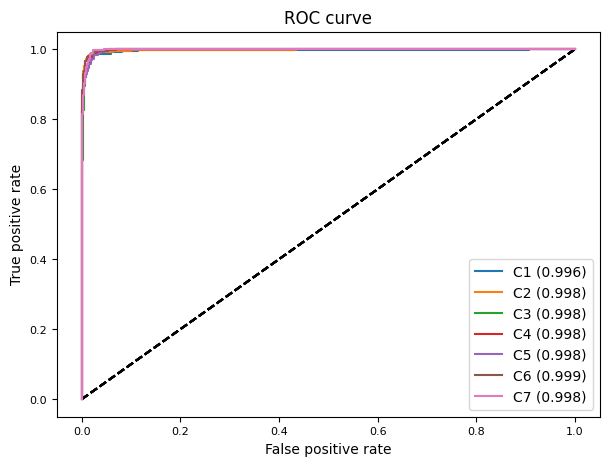

In [28]:
y_pred_4 = model_4.predict(X_test)
auc_rocs_4 = get_roc_curve(labels, y_pred_4, y_test)

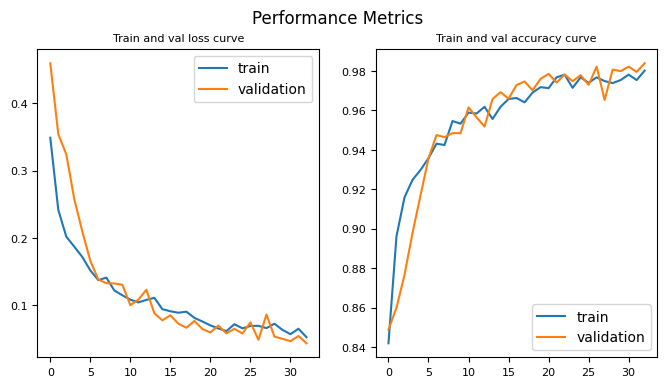

In [29]:
# Visualize the accuracy and loss for model training per epoch
plot_history(history_model_4)

In [ ]:
# Get the class-wise scores on the test data
y_pred_4 = model_4.predict(X_test)
threshold = 0.5
y_pred_binary_4 = (y_pred_4 > threshold).astype(int)
score_4 = model_4.evaluate(X_test, y_test, verbose = 1)
df_met_model_4 = metrics(y_test, y_pred_binary_4)
print(f'Test loss:{score_4[0]}\n Test accuracy:{score_4[1]}')
df_met_model_4

94/94 [==============================] - 6s 61ms/step - loss: 0.0439 - binary_accuracy: 0.9840
Test loss:0.04391441494226456
 Test accuracy:0.9839620590209961


,Class,Sensitivity,Specificity,F1-score
0,C1,0.922500,0.948586,0.935361
1,C2,0.984756,0.945827,0.964899
2,C3,0.968974,0.914414,0.940904
3,C4,0.952607,0.924138,0.938156
4,C5,0.941964,0.925439,0.933628
5,C6,0.978308,0.933747,0.955508
6,C7,0.997963,0.895795,0.944123


94/94 [==============================] - 5s 58ms/step


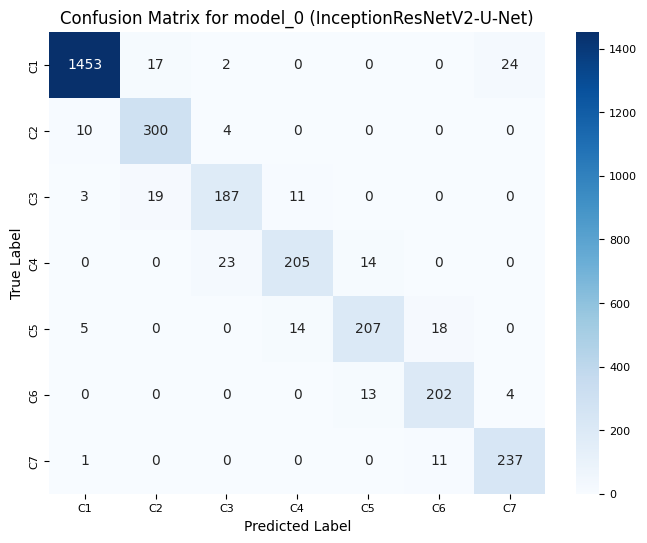

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 1: Make Predictions on the Test Data
y_pred_4 = model_4.predict(X_test)  # Make predictions on test data

# Step 2: Convert Predictions to Binary (0/1) using a Threshold 
threshold = 0.5
y_pred_binary_4 = (y_pred_4 > threshold).astype(int)

# Step 3: Calculate the Confusion Matrix
# Assuming y_test is one-hot encoded, flatten it
y_true = y_test.argmax(axis=1)  # True labels (flattened)
y_pred = y_pred_binary_4.argmax(axis=1)  # Predicted labels (flattened)

# Step 4: Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 5: Display the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'], yticklabels=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for model_0 (InceptionResNetV2-U-Net)')
plt.show()

94/94 [==============================] - 5s 58ms/step


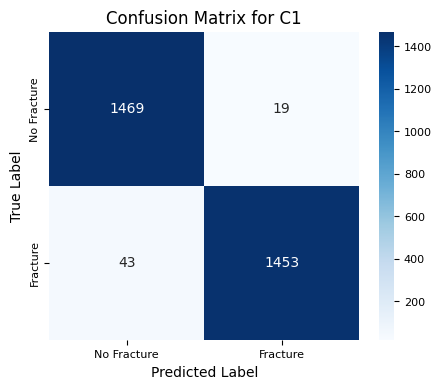

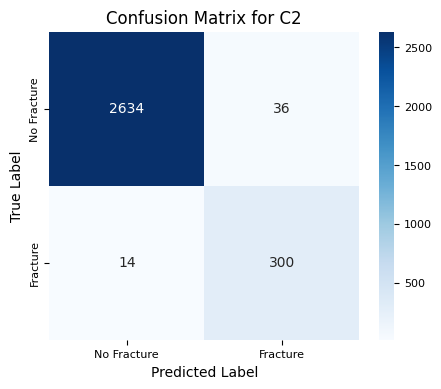

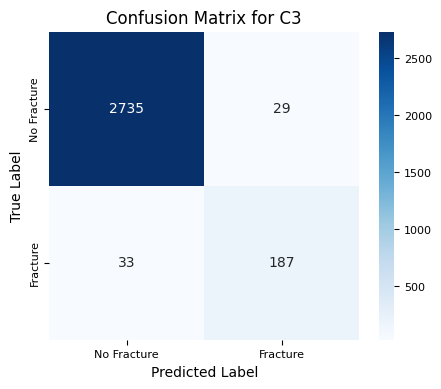

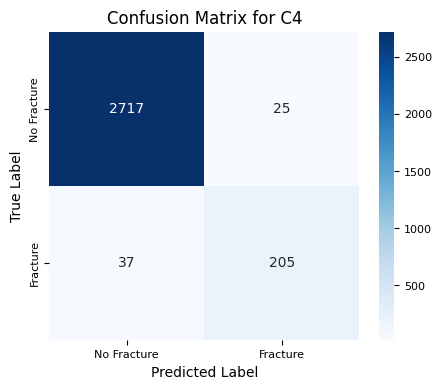

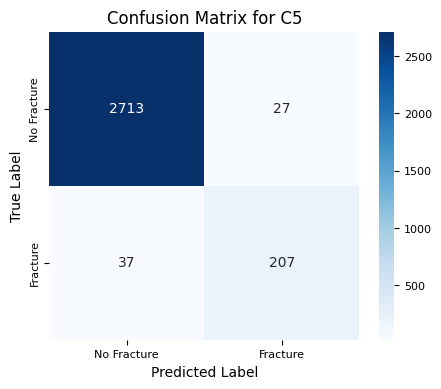

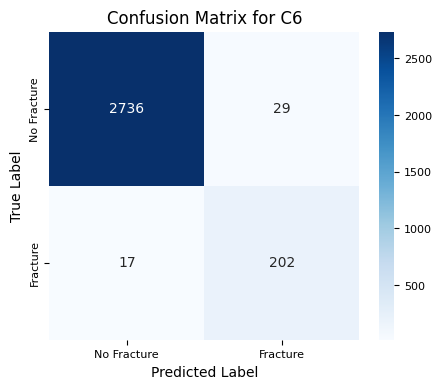

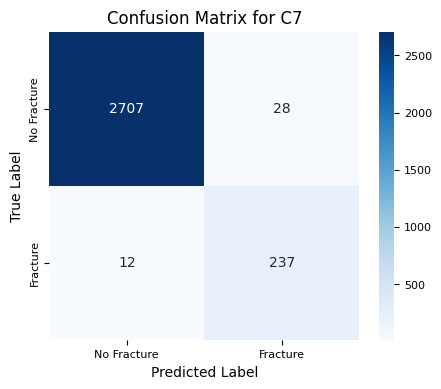

In [39]:
# Step 1: Make Predictions on the Test Data
y_pred_4 = model_4.predict(X_test)  # Make predictions on test data

# Step 2: Convert Predictions to Binary (0/1) using a Threshold 
threshold = 0.5
y_pred_binary_4 = (y_pred_4 > threshold).astype(int)

# Step 3: Flatten the true labels and predicted labels
y_true = y_test.argmax(axis=1)  # True labels (flattened)
y_pred = y_pred_binary_4.argmax(axis=1)  # Predicted labels (flattened)

# Step 4: Plot separate confusion matrix for each class
classes = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

# Iterate over each class and create a separate confusion matrix
for i in range(len(classes)):
    # For each class, create a binary label (class vs all others)
    y_true_class = (y_true == i).astype(int)
    y_pred_class = (y_pred == i).astype(int)

    # Compute the confusion matrix for the current class
    cm_class = confusion_matrix(y_true_class, y_pred_class)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_class, annot=True, fmt="d", cmap="Blues", xticklabels=['No Fracture', 'Fracture'], yticklabels=['No Fracture', 'Fracture'])
    plt.title(f"Confusion Matrix for {classes[i]}")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [42]:
def load_image(seg_labels, img_idx, preprocess=True):
    '''
    Takes the image index and outputs the subsequent 3 channeled image.
    '''
    study_id = seg_labels.loc[img_idx,'StudyInstanceUID']
    slice_id = seg_labels.loc[img_idx,'slice']+'.dcm'
    study_path = study_id+'/'+slice_id
    base_path = train_images
    path = os.path.join(base_path, study_path)
    label = [seg_labels.loc[img_idx,f'C{j}'] for j in range(1,8)]
    
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data=get_pixels_hu(img)
    if preprocess:
        data=data-np.min(data)
        if np.max(data) != 0:
            data=data/np.max(data)
        data=(data*255).astype(np.uint8) 
        data = cv2.cvtColor(data.reshape(128, 128), cv2.COLOR_GRAY2RGB)
    image = data / 255.0
    return image, label

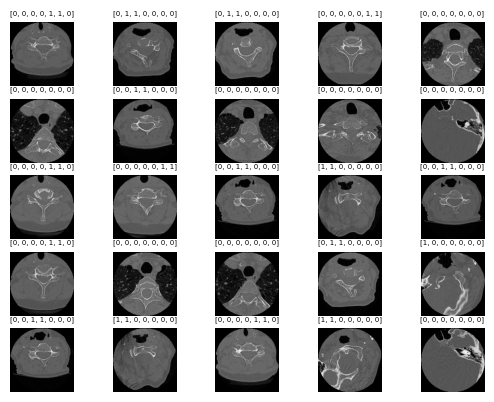

In [43]:
study_instance = '1.2.826.0.1.3680043.1868'
instances = list(seg_labels[seg_labels['StudyInstanceUID']==study_instance].index)
for i in range(instances[0], instances[25]):
    img, label = load_image(seg_labels, i, preprocess=False)
    plt.subplot(5, 5, i+1-instances[0])
    plt.title(label, fontsize=5)
    plt.imshow(img, cmap='gray')
    plt.axis(False)

In [44]:
def compute_gradcam(model, img_idx, df, labels, layer_name='bn', W=128, H=128):    
    preprocessed_input, label = load_image(df, img_idx)
    print(label)
    preprocessed_img = np.expand_dims(preprocessed_input, axis=0)
    predictions = model.predict(preprocessed_img)
    
    ##############################
    print("Loading original image")
    plt.figure(figsize=(12, 2))
    plt.suptitle(f'Patient_ID: {seg_labels.loc[img_idx].StudyInstanceUID}| Slice: {seg_labels.loc[img_idx].slice}', fontsize=10)
    plt.subplot(1, 8, 1)
    plt.title("Original", fontsize=8)
    plt.axis('off')
    plt.imshow(preprocessed_input, cmap='gray')
    ##############################
    
    conv_output = model.get_layer(layer_name).output
    gradModel = Model(
                inputs=[model.inputs],
                outputs=[conv_output,model.output])
    
    for i in range(len(labels)):
#         if labels[i] in selected_labels:
        print(f"Generating gradcam for class {labels[i]}")

        cls = i # specific class output probability
        with tf.GradientTape() as tape:
            (convOutputs, pred) = gradModel(preprocessed_img)
            loss = pred[:, cls]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        output, grads_val = convOutputs[0, :], grads[0, :, :, :] #no need of batch information

        weights = np.mean(grads_val, axis=(0, 1))
        cam = np.dot(output, weights)

        # Process CAM
        cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        gradcam = cam / cam.max()

        ###############################
        plt.subplot(1, 8, i+2)
        plt.title(f"{labels[i]}: A={label[i]},P={predictions[0][i]:.3f}", fontsize=8)
        plt.axis('off')
        plt.imshow(preprocessed_input,cmap='gray')

        #value = np.array(min(0.5, predictions[0][i])).reshape(1,1)
        value = min(0.5, predictions[0][i])
        value = np.repeat(value,W*H).reshape(W,H)
        plt.imshow(gradcam, cmap='jet', alpha=value)
        #################################


27293
[0, 1, 0, 0, 0, 0, 0]
1/1 [==============================] - 0s 37ms/step
Loading original image
Generating gradcam for class C1


/tmp/ipykernel_32/1341453422.py:41: RuntimeWarning: invalid value encountered in divide
  gradcam = cam / cam.max()


Generating gradcam for class C2
Generating gradcam for class C3
Generating gradcam for class C4
Generating gradcam for class C5
Generating gradcam for class C6
Generating gradcam for class C7


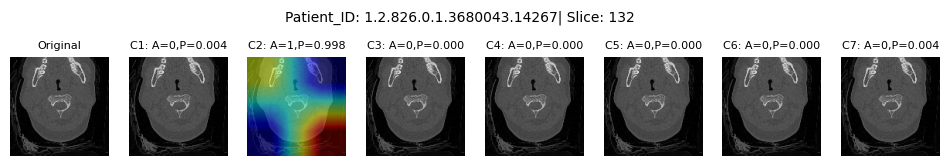

In [52]:
layer_name_2='conv_7b_bn'  #'conv5_block16_2_conv'
img_idx = 27293 #np.random.randint(0, len(seg_labels))
print(img_idx)
compute_gradcam(model=model_4, img_idx=img_idx, df=seg_labels, labels=labels, layer_name=layer_name_2)

3860
[1, 1, 0, 0, 0, 0, 0]
1/1 [==============================] - 0s 39ms/step
Loading original image
Generating gradcam for class C1
Generating gradcam for class C2
Generating gradcam for class C3
Generating gradcam for class C4


/tmp/ipykernel_32/1341453422.py:41: RuntimeWarning: invalid value encountered in divide
  gradcam = cam / cam.max()


Generating gradcam for class C5
Generating gradcam for class C6
Generating gradcam for class C7


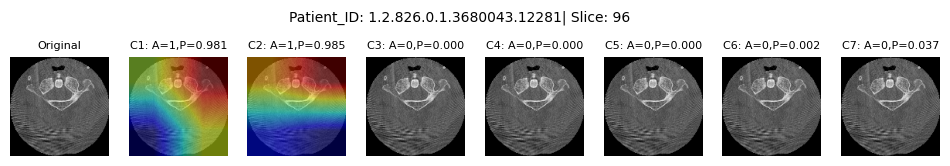

In [53]:
layer_name_4 = 'conv_7b_bn'
img_idx = 3860 #np.random.randint(0, len(seg_labels))
print(img_idx)
compute_gradcam(model=model_4, img_idx=img_idx, df=seg_labels, labels=labels, layer_name=layer_name_4)

1/1 [==============================] - 3s 3s/step
All vertebrae fracture probabilities:
  C1: 0.0026
  C2: 0.9995
  C3: 0.0002
  C4: 0.0000
  C5: 0.0000
  C6: 0.0002
  C7: 0.0002
Fracture detected in vertebrae: C2
Probabilities (above threshold): {'C2': '0.9995'}


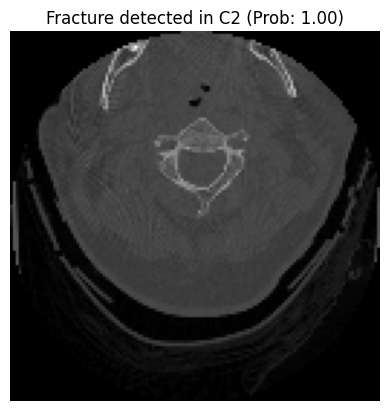

In [56]:
import pydicom as dicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Replace this with your loaded model variable
model_0 = load_model('/kaggle/working/model_4_InceptionResNetV2.h5')

def get_pixels_hu(img):
    """Convert DICOM pixel data to Hounsfield Units (HU) and resize to 128x128."""
    image = cv2.resize(img.pixel_array, (128, 128), interpolation=cv2.INTER_NEAREST)
    image = image.astype(np.int16)
    image[image <= -1000] = 0
    intercept = getattr(img, 'RescaleIntercept', 0)
    slope = getattr(img, 'RescaleSlope', 1)
    image = slope * image.astype(np.float64) + intercept
    return image.astype(np.int16)

def load_and_preprocess_image(path):
    """Load DICOM image, convert to HU, normalize and convert to RGB 128x128."""
    img = dicom.dcmread(path)
    hu_image = get_pixels_hu(img)
    hu_image = hu_image - np.min(hu_image)
    if np.max(hu_image) != 0:
        hu_image = hu_image / np.max(hu_image)
    hu_image = (hu_image * 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(hu_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

def predict_fracture(image_path, model, threshold=0.5):
    vertebra_labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

    # Load and preprocess image
    img = load_and_preprocess_image(image_path)
    input_img = img_to_array(img) / 255.0
    input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension

    # Predict probabilities
    proba = model.predict(input_img)[0]

    # Print all probabilities for all vertebrae
    print("All vertebrae fracture probabilities:")
    for v, p in zip(vertebra_labels, proba):
        print(f"  {v}: {p:.4f}")

    # Find vertebrae with probability > threshold
    fractured_indices = [i for i, p in enumerate(proba) if p > threshold]

    # Display results
    plt.imshow(img)
    plt.axis('off')

    if len(fractured_indices) == 0:
        plt.title(f"No fracture detected (all probabilities ≤ {threshold:.2f})")
        print("No fracture detected.")
    else:
        # Find vertebra with highest probability among fractured
        max_index = fractured_indices[np.argmax(proba[fractured_indices])]
        max_vertebra = vertebra_labels[max_index]
        max_prob = proba[max_index]

        fractured_vertebrae = [vertebra_labels[i] for i in fractured_indices]
        fractured_probs = [proba[i] for i in fractured_indices]

        plt.title(f"Fracture detected in {max_vertebra} (Prob: {max_prob:.2f})")
        print(f"Fracture detected in vertebrae: {', '.join(fractured_vertebrae)}")
        print("Probabilities (above threshold):", {v: f"{p:.4f}" for v, p in zip(fractured_vertebrae, fractured_probs)})

    plt.show()
    plt.show()

# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.22327/101.dcm'
predict_fracture(image_path, model_0)


1/1 [==============================] - 0s 37ms/step
All vertebrae fracture probabilities:
  C1: 0.0000
  C2: 0.0005
  C3: 0.0004
  C4: 0.0000
  C5: 0.0001
  C6: 0.0769
  C7: 0.9992
Fracture detected in vertebrae: C7
Probabilities (above threshold): {'C7': '0.9992'}


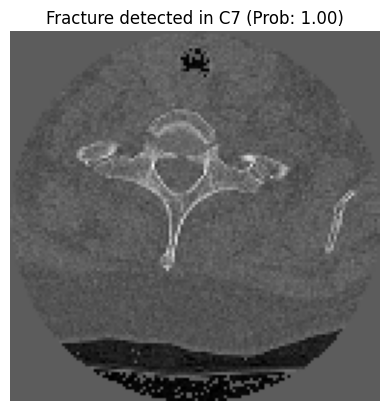

In [61]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.5876/324.dcm'
predict_fracture(image_path, model_0)

1/1 [==============================] - 0s 38ms/step
All vertebrae fracture probabilities:
  C1: 0.0826
  C2: 0.0135
  C3: 0.0004
  C4: 0.0020
  C5: 0.0009
  C6: 0.0013
  C7: 0.0268
No fracture detected.


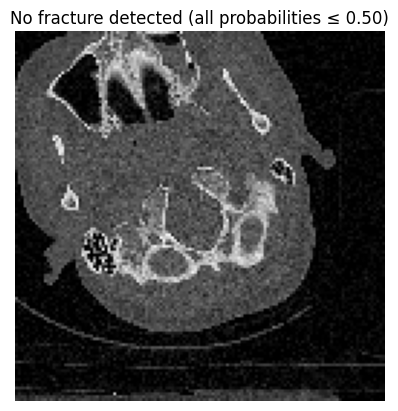

In [58]:
# Example usage:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/1.2.826.0.1.3680043.25399/101.dcm'
predict_fracture(image_path, model_0)